# Merging subclustering result

In [1]:
## loading packages
library(Seurat)
library(ggplot2)
library(magrittr)
library(data.table)
library(Matrix)
library(dplyr)
library(tibble)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
#loading dataset before subclustering
seu_HQC <- readRDS(file = "../../data/seurat_object/Set3/seu_HQC_Set3.obj")

In [3]:
seu_HQC

An object of class Seurat 
28756 features across 6180 samples within 2 assays 
Active assay: SCT (11250 features, 3000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


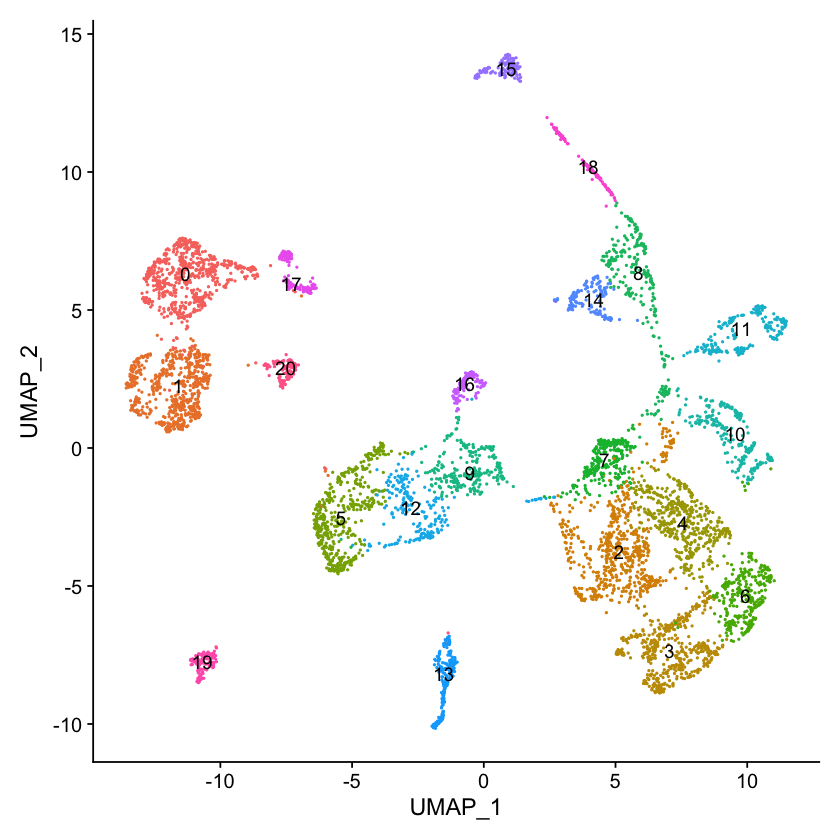

In [4]:
DimPlot(seu_HQC, reduction =  "umap", label = TRUE) + NoLegend()

## Merging results

In [5]:
#loading subclustering results
seu.ecto <- readRDS(file = '../../data/seurat_object/Set3/subclustering/seu_lateral_ecto_subclustered.obj')
seu.meso <- readRDS(file = '../../data/seurat_object/Set3/subclustering/seu_meso_subclustered.obj')
seu.head <- readRDS(file = '../../data/seurat_object/Set3/subclustering/seu_head_subclustered.obj')
seu.ps1 <- readRDS(file = '../../data/seurat_object/Set3/subclustering/seu_PS1_subclustered.obj')
seu.post <- readRDS(file = '../../data/seurat_object/Set3/subclustering/seu_post_end_subclustered.obj')
seu.midline <- readRDS(file = '../../data/seurat_object/Set3/subclustering/seu_midline_subclustered.obj')
seu.ecto
seu.meso
seu.head
seu.ps1
seu.post
seu.midline

An object of class Seurat 
27314 features across 2350 samples within 2 assays 
Active assay: SCT (9808 features, 3000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

An object of class Seurat 
28756 features across 1977 samples within 2 assays 
Active assay: RNA (17506 features, 0 variable features)
 1 other assay present: SCT

An object of class Seurat 
28756 features across 395 samples within 2 assays 
Active assay: SCT (11250 features, 3000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

An object of class Seurat 
28756 features across 217 samples within 2 assays 
Active assay: RNA (17506 features, 0 variable features)
 1 other assay present: SCT
 2 dimensional reductions calculated: pca, umap

An object of class Seurat 
26560 features across 921 samples within 2 assays 
Active assay: SCT (9054 features, 3000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

An object of class Seurat 
28756 features across 135 samples within 2 assays 
Active assay: RNA (17506 features, 0 variable features)
 1 other assay present: SCT
 2 dimensional reductions calculated: pca, umap

In [6]:
#Add anotation info into pole cells
seu.polecell <- subset(seu_HQC,idents=c('19'))
seu.polecell$manual_ID <- 'pole_cells'

In [7]:
#Merge all subclustering results
#Subclustering results contains only singlet
seu.singlet <- merge(seu.ecto, y = c(seu.meso,seu.head,seu.ps1,seu.post,seu.midline,seu.polecell))
seu.singlet

An object of class Seurat 
28756 features across 6118 samples within 2 assays 
Active assay: SCT (11250 features, 0 variable features)
 1 other assay present: RNA

In [8]:
singlet.list <- colnames(seu.singlet)

In [9]:
#pick up doublets
seu.doublet <- subset(seu_HQC, cells = singlet.list, invert = TRUE)
seu.doublet

An object of class Seurat 
28756 features across 62 samples within 2 assays 
Active assay: SCT (11250 features, 3000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [10]:
seu.doublet$manual_ID <- 'doublet'

In [11]:
doublet.list <- colnames(seu.doublet)
write(doublet.list, './doublet_names.txt')

## Add subclustering results into HQC dataset

In [12]:
seu.merge <- merge(seu.singlet,seu.doublet)
seu_HQC$manual_ID <- seu.merge$manual_ID

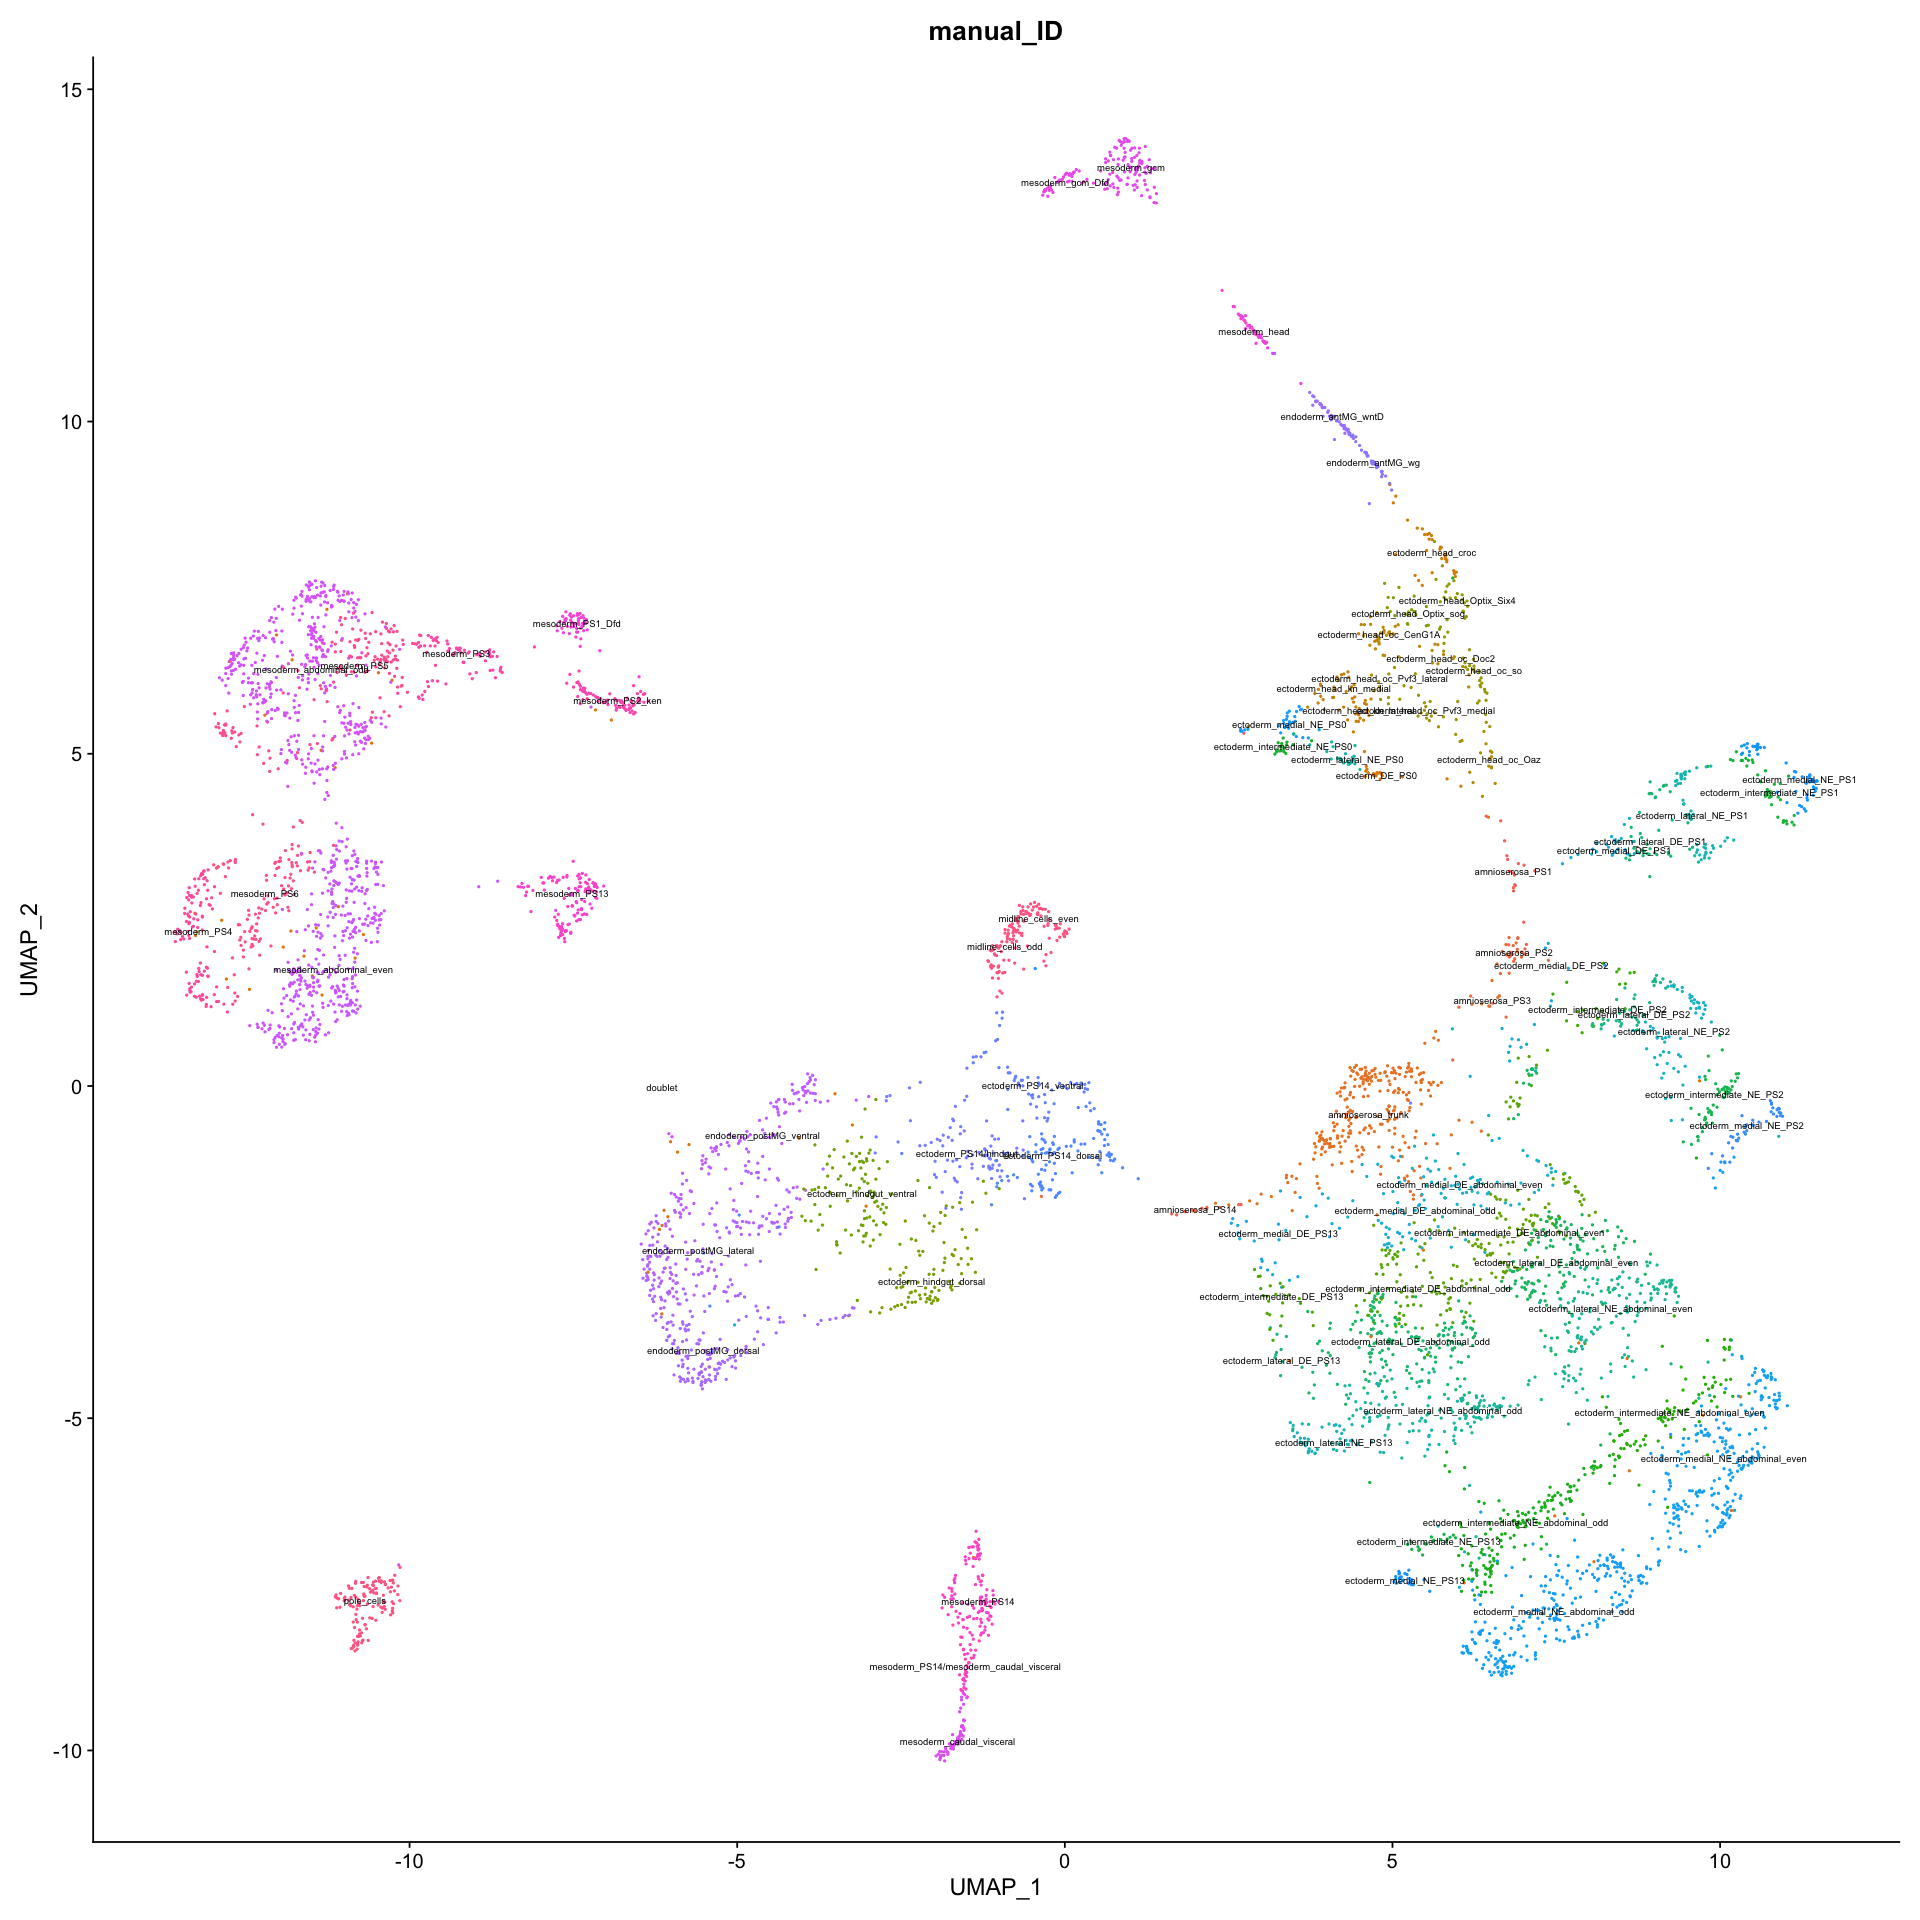

In [13]:
options(repr.plot.width=16, repr.plot.height=16)
DimPlot(seu_HQC, reduction = 'umap', label.size = 2, group.by = 'manual_ID', label = T) + NoLegend()

In [14]:
write.table(as.data.frame(seu_HQC$manual_ID), sep='\t', file='./manual_ID.txt', col.names=FALSE)

In [15]:
Idents(seu_HQC) <- 'manual_ID'

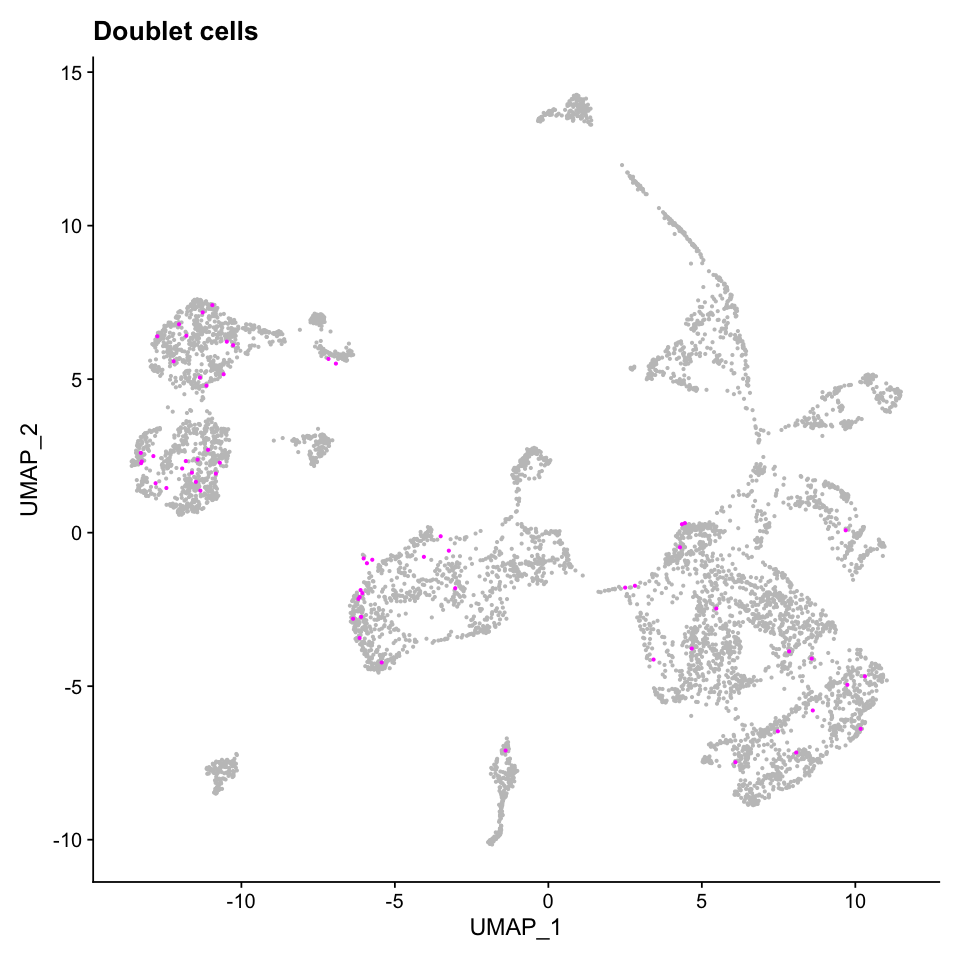

In [16]:
options(repr.plot.width=8, repr.plot.height=8)
highlight.cells <- WhichCells(seu_HQC,idents = c('doublet'))
DimPlot(seu_HQC, reduction =  "umap", cells.highlight = highlight.cells, pt.size = 0.5, sizes.highlight = 0.5,
        cols.highlight = 'magenta', label = FALSE) + NoLegend() + ggtitle('Doublet cells')

## Removing doublets for downstream analysis

In [17]:
seu.singlet <- subset(seu_HQC,idents = c('doublet'), invert=TRUE)
seu.singlet

An object of class Seurat 
28756 features across 6118 samples within 2 assays 
Active assay: SCT (11250 features, 3000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [18]:
singlet.names.old <- read.csv('./singlet_names.txt', header = FALSE)$V1 #singlet list of analysis before revise
head(singlet.names.old)

[1] "AAAGAACGTGTTCGTA" "AACACACTCGTGGAAG" "AACCTTTCACCCTCTA" "AATGCCAAGTCAGGGT"
[5] "ACACAGTAGAAGGATG" "ACAGCCGGTTAGGCTT"

In [19]:
setdiff(colnames(seu.singlet), singlet.names.old) #Checking singlets are the same cells as ones before revise

character(0)

In [20]:
seu.singlet <- subset(seu_HQC, cells = singlet.names.old)
#Sort cells into the same order before the revise.

## Renormalize using only singlet cells

In [21]:
DefaultAssay(seu.singlet) <- 'RNA'
seu.singlet <- suppressWarnings(SCTransform(seu.singlet, vars.to.regress = c('percent.mt','percent.rRNA')))

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 11239 by 6118

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 6118 cells



  |======================================================================| 100%


Found 168 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 11239 genes



  |======================================================================| 100%


Computing corrected count matrix for 11239 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.287842 mins

Determine variable features

Set 3000 variable features

Place corrected count matrix in counts slot

Regressing out percent.mt, percent.rRNA

Centering data matrix

Set default assay to SCT



In [22]:
seu.singlet <- RunPCA(seu.singlet)
seu.singlet <- RunUMAP(seu.singlet, dims=1:30, reduction.name = 'reumap', n.neighbors = 20L)

PC_ 1 
Positive:  twi, Ilp4, hll, CadN, sprt, Cyp310a1, tin, htl, zfh1, VepD 
	   CG3036, SNCF, CG12177, Mef2, Mes2, Pka-C3, stg, CG14688, Ama, wntD 
	   Act87E, stumps, Mdr49, sna, CG43355-sala, Nplp2, sty, CG11357, CG7029, be 
Negative:  CG13427, SoxN, Lac, CG34224, CG10035, ImpL2, Atx-1, Dl, aop, sog 
	   CG15628, cv-2, hth, ths, crb, ASPP, blot, Tet, E(spl)m4-BFM, Ptr 
	   Tom, sca, CG13217, CG15480, CG4440, sdt, Antp, Brd, mew, grh 
PC_ 2 
Positive:  fkh, peb, ps, Doc1, Pdp1, srp, Doc3, egr, Gmap, Oatp74D 
	   pgc, BigH1, CG2930, Eno, stai, 26-29-p, Pepck-CG45087, nos, Tao, p23 
	   CycB, fabp-sea, spri, DNaseII, hkb, mnd, Jafrac1, dap, shu, PyK 
Negative:  SoxN, Ilp4, twi, ImpL2, trn, hth, CG43355-sala, sog, Toll-6, sca 
	   Tollo, CadN, ths, stg, hll, sprt, tin, slp1, robo2, Antp 
	   D, htl, HmgD, pri, tsh, CG34224, Ubx, CG15628, CG4440, wntD 
PC_ 3 
Positive:  SoxN, sog, ImpL2, sca, ths, Toll-6, D, Tollo, nos, lok 
	   MED26, stai, 26-29-p, wisp, pgc, BigH1, Hsp27, Eno, Tao, s

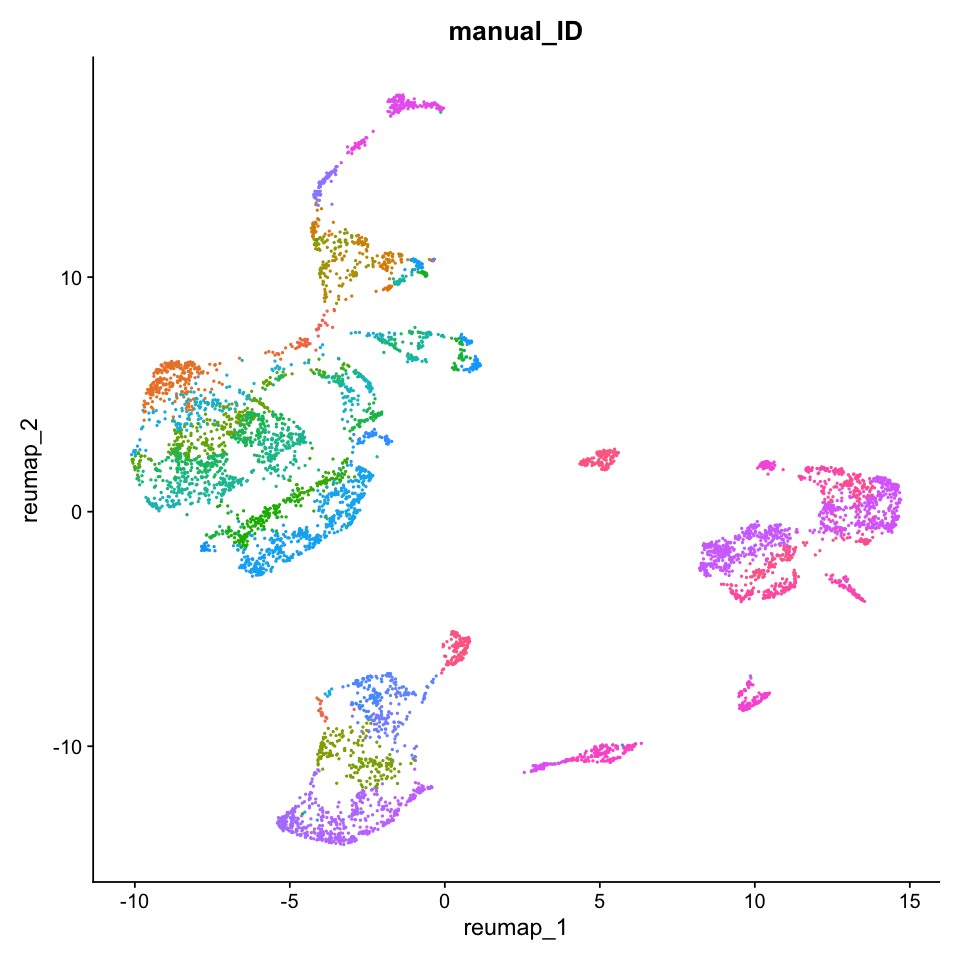

In [23]:
options(repr.plot.width=8, repr.plot.height=8)
p1 <- DimPlot(seu.singlet, reduction = 'reumap', label.size = 8, group.by = 'manual_ID') + NoLegend()
plot(p1)

In [24]:
seu.singlet

An object of class Seurat 
28745 features across 6118 samples within 2 assays 
Active assay: SCT (11239 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, reumap

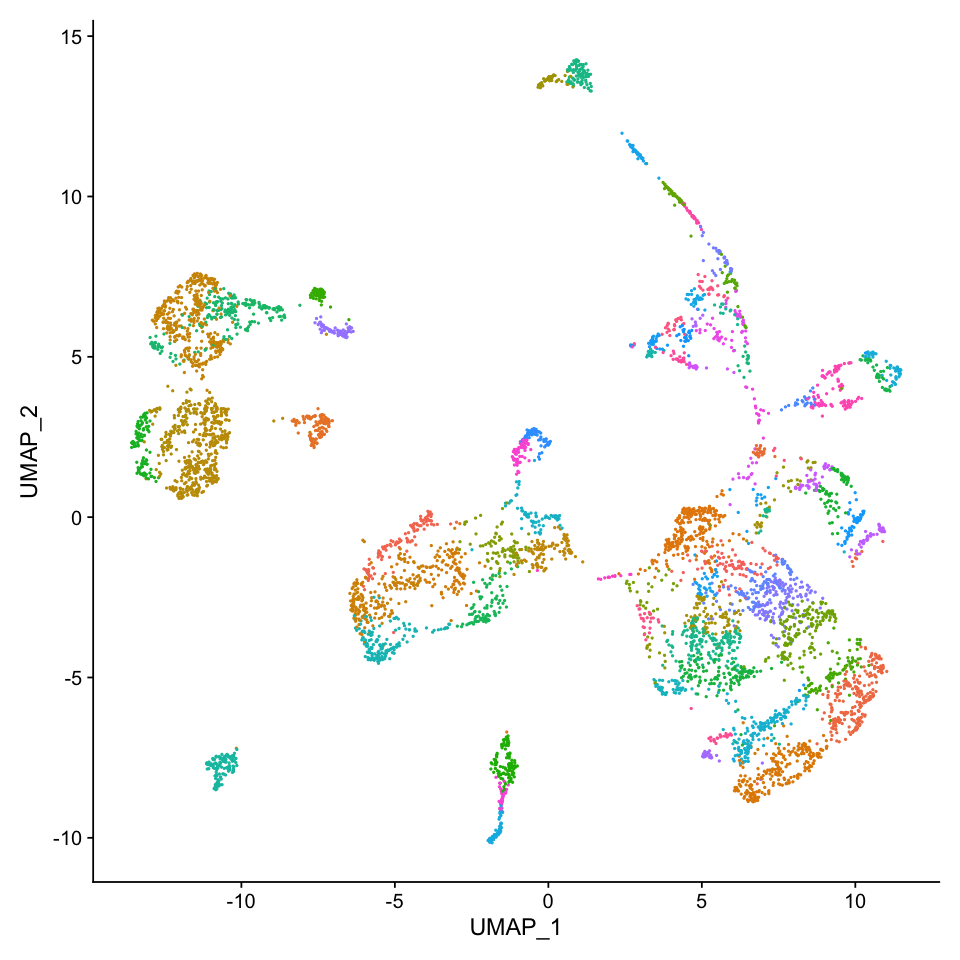

In [25]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(seu.singlet, reduction =  "umap", label = FALSE) + NoLegend()

In [26]:
# dataset with doublet
saveRDS(seu_HQC, file = '../../data/seurat_object/Set3/seu_HQC_subclusterd_Set3.obj')

In [27]:
levels <- read.table(file="./manual_ID_list/manual_ID_levels_color.txt",comment.char = "")
colors <- levels[,2]
levels <- levels[,1]
head(levels)
length(levels)
head(colors)

[1] "ectoderm_head_croc"       "ectoderm_head_Optix_Six4"
[3] "ectoderm_head_Optix_sog"  "ectoderm_head_oc_so"     
[5] "ectoderm_head_oc_Doc2"    "ectoderm_head_oc_CenG1A"

[1] 77

[1] "lightsteelblue1" "lightsteelblue2" "lightsteelblue3" "lightskyblue1"  
[5] "lightskyblue2"   "lightskyblue3"

In [28]:
length(levels(seu_HQC))
levels(seu_HQC)

[1] 78

[1] "ectoderm_medial_DE_abdominal_even"      
 [2] "endoderm_postMG_ventral"                
 [3] "ectoderm_medial_NE_abdominal_even"      
 [4] "amnioserosa_PS2"                        
 [5] "mesoderm_PS13"                          
 [6] "amnioserosa_trunk"                      
 [7] "ectoderm_medial_NE_abdominal_odd"       
 [8] "ectoderm_hindgut_ventral"               
 [9] "endoderm_postMG_lateral"                
[10] "mesoderm_abdominal_odd"                 
[11] "ectoderm_PS14_dorsal"                   
[12] "mesoderm_abdominal_even"                
[13] "mesoderm_PS6"                           
[14] "ectoderm_intermediate_DE_abdominal_odd" 
[15] "mesoderm_gcm_Dfd"                       
[16] "ectoderm_intermediate_DE_PS2"           
[17] "ectoderm_lateral_DE_PS13"               
[18] "ectoderm_PS14/hindgut"                  
[19] "ectoderm_medial_DE_PS13"                
[20] "ectoderm_lateral_NE_abdominal_even"     
[21] "endoderm_antMG_wntD"                    
[22] "ectoderm_head_Optix_Six4"               
[23] "ectoderm_intermediate_NE_abdominal_even"
[24] "mesoderm_PS1_Dfd"                       
[25] "mesoderm_PS14"                          
[26] "doublet"                                
[27] "mesoderm_PS4"                           
[28] "ectoderm_lateral_NE_PS2"                
[29] "ectoderm_lateral_NE_abdominal_odd"      
[30] "ectoderm_intermediate_NE_PS1"           
[31] "ectoderm_hindgut_dorsal"                
[32] "mesoderm_PS3"                           
[33] "mesoderm_PS5"                           
[34] "ectoderm_head_oc_Oaz"                   
[35] "mesoderm_gcm"                           
[36] "ectoderm_lateral_DE_abdominal_odd"      
[37] "ectoderm_head_oc_Doc2"                  
[38] "pole_cells"                             
[39] "ectoderm_intermediate_NE_PS0"           
[40] "endoderm_postMG_dorsal"                 
[41] "ectoderm_lateral_NE_PS13"               
[42] "ectoderm_PS14_ventral"                  
[43] "ectoderm_intermediate_NE_abdominal_odd" 
[44] "ectoderm_medial_NE_PS1"                 
[45] "mesoderm_caudal_visceral"               
[46] "ectoderm_head_oc_CenG1A"                
[47] "mesoderm_head"                          
[48] "ectoderm_medial_DE_abdominal_odd"       
[49] "ectoderm_medial_NE_PS0"                 
[50] "ectoderm_intermediate_NE_PS2"           
[51] "ectoderm_head_kn_lateral"               
[52] "midline_cells_even"                     
[53] "ectoderm_medial_DE_PS1"                 
[54] "ectoderm_intermediate_DE_abdominal_even"
[55] "ectoderm_head_croc"                     
[56] "ectoderm_lateral_DE_abdominal_even"     
[57] "mesoderm_PS2_ken"                       
[58] "ectoderm_medial_NE_PS13"                
[59] "ectoderm_head_oc_Pvf3_lateral"          
[60] "ectoderm_medial_NE_PS2"                 
[61] "ectoderm_lateral_DE_PS2"                
[62] "ectoderm_DE_PS0"                        
[63] "amnioserosa_PS3"                        
[64] "ectoderm_head_oc_so"                    
[65] "ectoderm_head_oc_Pvf3_medial"           
[66] "amnioserosa_PS1"                        
[67] "mesoderm_PS14/mesoderm_caudal_visceral" 
[68] "midline_cells_odd"                      
[69] "amnioserosa_PS14"                       
[70] "ectoderm_lateral_DE_PS1"                
[71] "ectoderm_lateral_NE_PS1"                
[72] "endoderm_antMG_wg"                      
[73] "ectoderm_lateral_NE_PS0"                
[74] "ectoderm_intermediate_NE_PS13"          
[75] "ectoderm_intermediate_DE_PS13"          
[76] "ectoderm_head_kn_medial"                
[77] "ectoderm_head_Optix_sog"                
[78] "ectoderm_medial_DE_PS2"

In [29]:
levels(seu.singlet) <- levels

Saving 7 x 7 in image



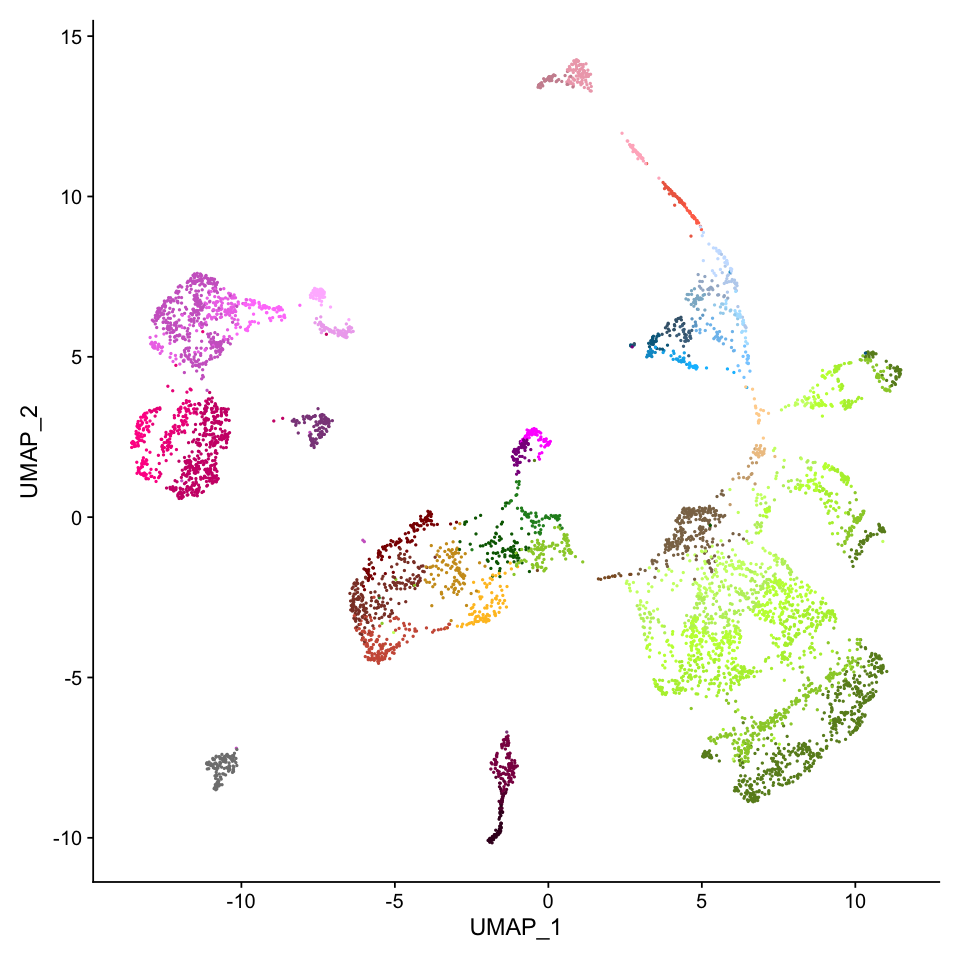

In [30]:
options(repr.plot.width=8, repr.plot.height=8)
fig <- DimPlot(seu.singlet, reduction =  "umap", label = FALSE, cols = colors) + NoLegend() 
fig
ggsave(fig, file = "./figures/08_merge_ID/all_cells_umap.eps", dpi = 300)

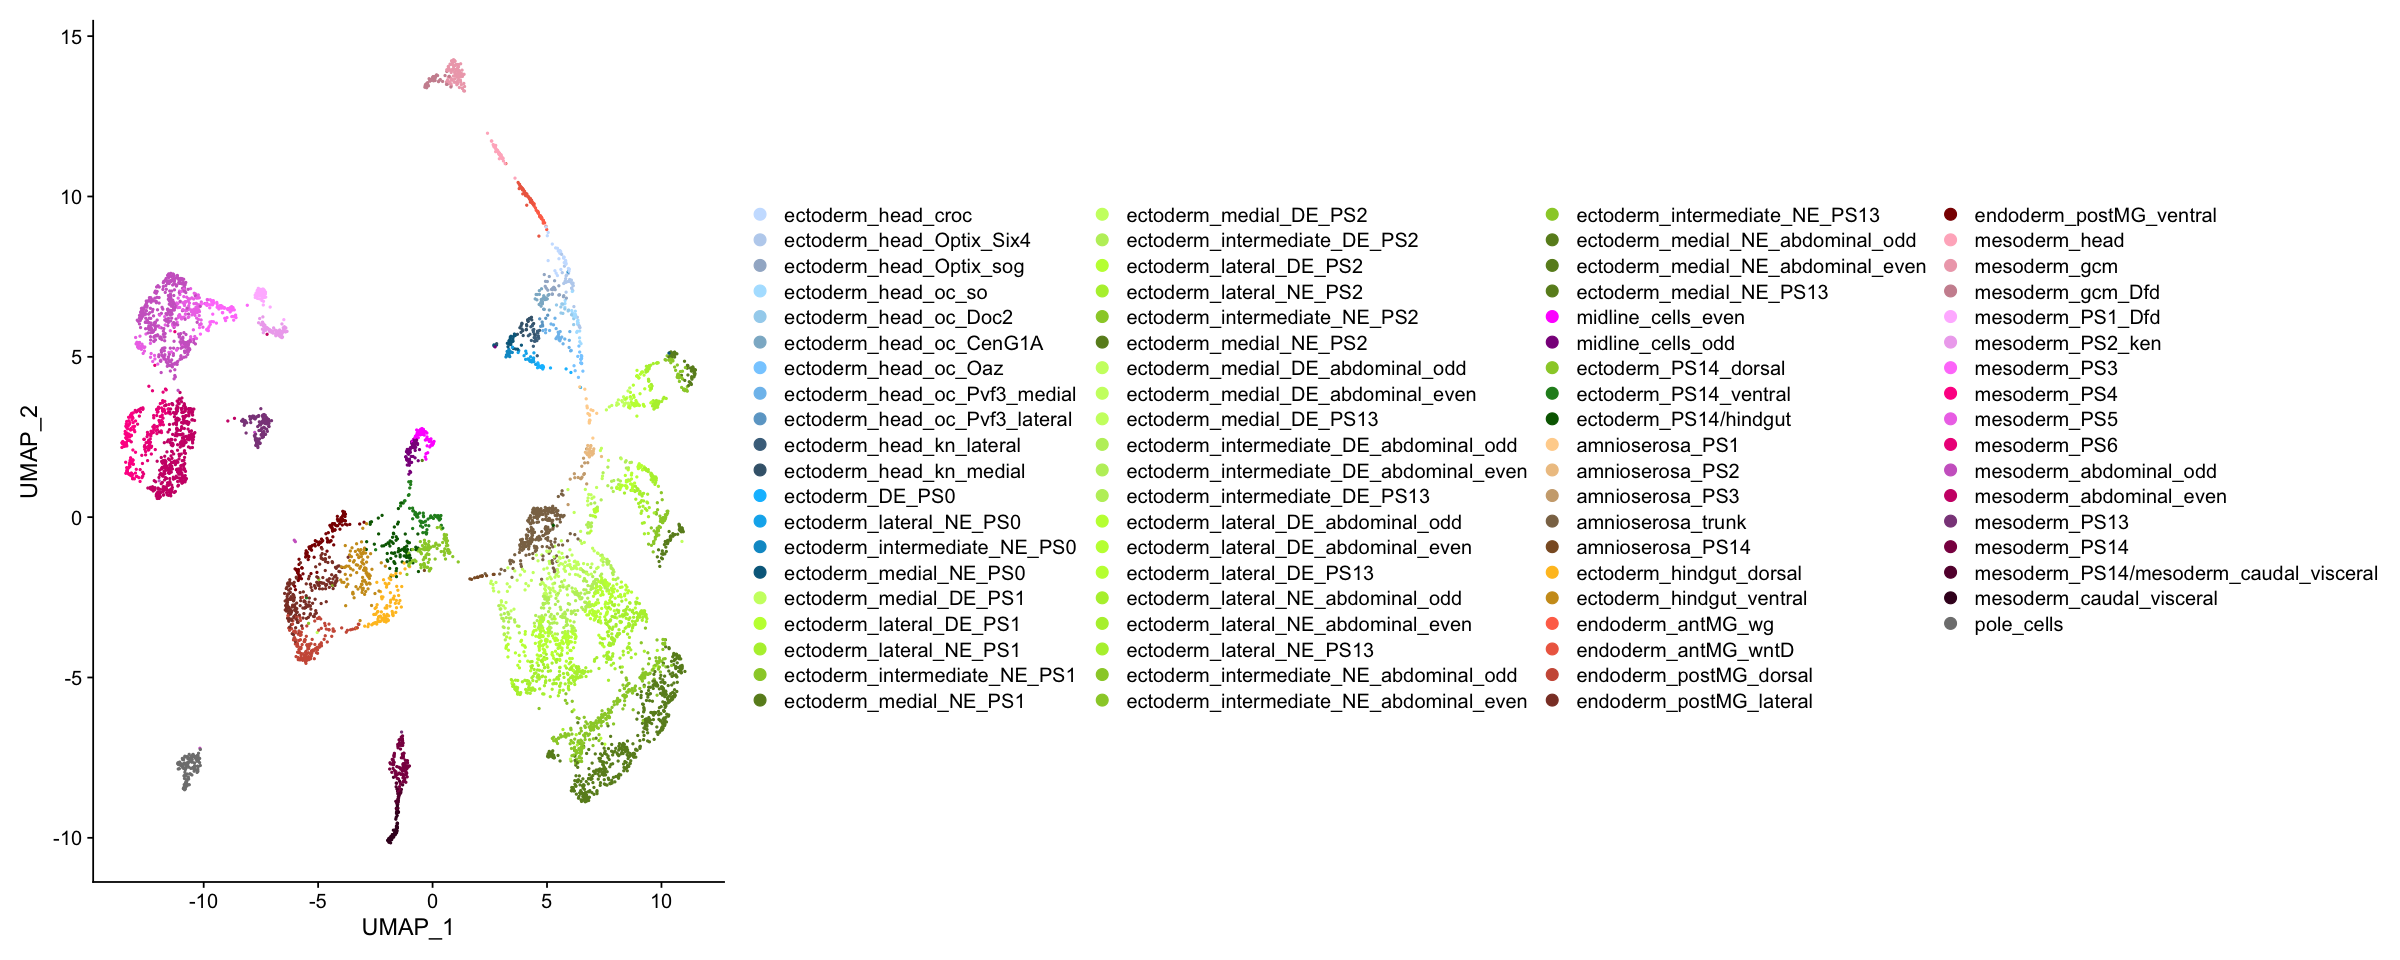

In [31]:
options(repr.plot.width=20, repr.plot.height=8)
fig <- DimPlot(seu.singlet, reduction =  "umap", label = FALSE, cols = colors)
fig
ggsave(fig, file = "./figures/08_merge_ID/all_cells_umap2.eps", dpi = 300, width =20, height = 8)

## Preparing conversion to loom file

In [32]:
manual_ID <- seu.singlet$manual_ID
unique.manual_ID <- unique(manual_ID)
manual_ID_num <- copy(manual_ID)
i <- 1
for (name in unique.manual_ID){
    rname <- paste('^',name, sep = '')
    rname <- paste(rname, '$', sep = '')
    manual_ID_num <- gsub(manual_ID_num, pattern = rname, replacement = i)
    i <- i + 1
}
seu.singlet$manual_ID_num <- manual_ID_num

In [33]:
unique(manual_ID_num)

[1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15"
[16] "16" "17" "18" "19" "20" "21" "22" "23" "24" "25" "26" "27" "28" "29" "30"
[31] "31" "32" "33" "34" "35" "36" "37" "38" "39" "40" "41" "42" "43" "44" "45"
[46] "46" "47" "48" "49" "50" "51" "52" "53" "54" "55" "56" "57" "58" "59" "60"
[61] "61" "62" "63" "64" "65" "66" "67" "68" "69" "70" "71" "72" "73" "74" "75"
[76] "76" "77"

In [34]:
# dataset without doublet
saveRDS(seu.singlet, file = '../../data/seurat_object/Set3/seu_HQC_subclusterd2_Set3.obj')

In [35]:
write.table(seu.singlet$manual_ID, file = 'manual_id_wo_doublet.csv', sep = ',', col.names = F)

In [44]:
write.table(seu.singlet$annotated_seurat_clusters, file = 'seurat_clusters_wo_doublet.csv', sep = ',', col.names = F)

In [36]:
umap.singlet <- Embeddings(seu.singlet, reduction = 'umap')
head(umap.singlet)

,UMAP_1,UMAP_2
AAAGAACGTGTTCGTA,4.039331,10.079795
AACACACTCGTGGAAG,2.821047,11.447732
AACCTTTCACCCTCTA,3.783507,10.244534
AATGCCAAGTCAGGGT,2.907481,11.359183
ACACAGTAGAAGGATG,2.758334,11.592550
ACAGCCGGTTAGGCTT,4.685133,9.377094


In [37]:
write.csv(umap.singlet, file = './UMAP_HQC_subclusterd_Set3.csv')

In [38]:
singlet.norm.count <- as.data.frame(GetAssayData(seu.singlet))
head(singlet.norm.count)

,AAAGAACGTGTTCGTA,AACACACTCGTGGAAG,AACCTTTCACCCTCTA,AATGCCAAGTCAGGGT,ACACAGTAGAAGGATG,ACAGCCGGTTAGGCTT,ACATCCCGTTACTCAG,ACCAACACACGGTCTG,ACCACAAGTACCTGTA,ACGATGTCAACGGTAG,⋯,TTTCACATCGTTGCCT,TTTCACATCTGATGGT,TTTCAGTCATGACTAC,TTTCATGAGGTCGTGA,TTTCCTCAGACTGTTC,TTTCGATAGAAGCCAC,TTTCGATGTGAGTGAC,TTTCGATGTGCAATAA,TTTGGTTTCTGGCTGG,TTTGTTGTCCACCTCA
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Myo81F,0,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,⋯,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
lncRNA:CR46122,0,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,⋯,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
CR40182,0,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,⋯,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
Pzl,0,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,⋯,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
spok,0,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,⋯,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
Parp,0,2.564949,1.94591,2.70805,1.386294,3.178054,2.833213,2.397895,2.564949,2.302585,⋯,1.94591,2.639057,2.079442,2.564949,2.302585,2.397895,2.302585,2.079442,2.484907,2.70805


In [39]:
write.csv(singlet.norm.count, file = './Norm_HQC_subclusterd_Set3.csv')

In [40]:
annot_df <- data.frame(list(
    cluster_id = 1:length(unique.manual_ID), 
    cluster_name = unique.manual_ID))
annot_df

cluster_id,cluster_name
<int>,<chr>
1,endoderm_antMG_wntD
2,mesoderm_head
3,endoderm_antMG_wg
4,ectoderm_intermediate_NE_PS1
5,ectoderm_medial_NE_PS1
6,ectoderm_medial_DE_PS1
7,ectoderm_lateral_DE_PS1
8,ectoderm_lateral_NE_PS1
9,amnioserosa_PS2


In [41]:
write.csv(annot_df, file = './annot_df.csv')

In [42]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Catalina 10.15.7

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] ja_JP.UTF-8/ja_JP.UTF-8/ja_JP.UTF-8/C/ja_JP.UTF-8/ja_JP.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] tibble_3.0.5      dplyr_1.0.3       Matrix_1.3-2      data.table_1.13.6
[5] magrittr_2.0.1    ggplot2_3.3.3     Seurat_3.2.3     

loaded via a namespace (and not attached):
  [1] nlme_3.1-151          matrixStats_0.57.0    RcppAnnoy_0.0.18     
  [4] RColorBrewer_1.1-2    httr_1.4.2            repr_1.1.0           
  [7] sctransform_0.3.2     tools_4.0.3           R6_2.5.1             
 [10] irlba_2.3.3           rpart_4.1-15          KernSmooth_2.23-18   
 [13] uwot_0.1.10           mgcv